In [1]:
from sklearn.decomposition import TruncatedSVD
from scipy.sparse.linalg import svds

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [3]:
# step1) load data
rating_data = pd.read_csv('../input_data/movie/ratings.csv')
movie_data = pd.read_csv('../input_data/movie/movies.csv')

rating_data.head() # 사용자가 매긴 영화 평점 데이터 

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [4]:
movie_data.head() #영화 제목 & 장르 데이터 

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
print(movie_data.shape)
print(rating_data.shape)

(9125, 3)
(100004, 4)


In [6]:
# step2) 전처리 

rating_data.drop('timestamp', axis = 1, inplace = True)
rating_data.head()

,userId,movieId,rating
0,1,31,2.5
1,1,1029,3.0
2,1,1061,3.0
3,1,1129,2.0
4,1,1172,4.0


In [7]:

movie_data.drop('genres', axis = 1, inplace = True)
movie_data.head()

,movieId,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)


In [8]:
user_movie_data = pd.merge(rating_data, movie_data, on = 'movieId')
user_movie_data.head()

,userId,movieId,rating,title
0,1,31,2.5,Dangerous Minds (1995)
1,7,31,3.0,Dangerous Minds (1995)
2,31,31,4.0,Dangerous Minds (1995)
3,32,31,4.0,Dangerous Minds (1995)
4,36,31,3.0,Dangerous Minds (1995)


In [9]:
user_movie_data.shape

(100004, 4)

In [11]:
user_movie_rating = user_movie_data.pivot_table('rating', index = 'userId', columns='title').fillna(0)
user_movie_rating.shape

(671, 9064)

In [12]:
user_movie_rating.head() # 행: 유저, 열: 영화 제목 

title,"""Great Performances"" Cats (1998)",$9.99 (2008),'Hellboy': The Seeds of Creation (2004),'Neath the Arizona Skies (1934),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),...,Zulu (1964),Zulu (2013),[REC] (2007),eXistenZ (1999),loudQUIETloud: A Film About the Pixies (2006),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931),İtirazım Var (2014)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
movie_user_rating = user_movie_rating.values.T
movie_user_rating.shape

(9064, 671)

In [15]:
# 메인!
# 하나의 영화에 대해서 비슷한 영화를 추천해주는 기능 구현하기
# SVD(Singular Value Decomposion), 특이값 분해란 m x n 크기의 데이터 행렬 A를 아래와 같이 분해하는 것을 말합니다.

SVD = TruncatedSVD(n_components=12) # truncated SVD는 시그마 행렬의 대각원소(특이값) 가운데 상위 n개(지금은 12개 from 671개)만 골라낸 것. pca처럼 불필요한 feature 버리고 차원축소한 것 
matrix = SVD.fit_transform(movie_user_rating)
matrix.shape

(9064, 12)

In [16]:
matrix[0] # 12개의 component로 차원을 축소했습니다.

array([ 0.01227491,  0.00250753,  0.01554813, -0.03398418, -0.01443947,
        0.00359508, -0.00231971,  0.04531137, -0.01606584, -0.02079625,
        0.01210754, -0.00819019])

In [17]:
# 이제 이렇게 나온 데이터를 활용해서 피어슨 상관계수를 구합니다.
# 피어슨 상관계수는 변수들 간의 상관관계를 구하는 것(0~1)

corr = np.corrcoef(matrix)
corr.shape

(9064, 9064)

In [18]:
corr2 = corr[:200, :200]
corr2.shape

(200, 200)

<AxesSubplot:>

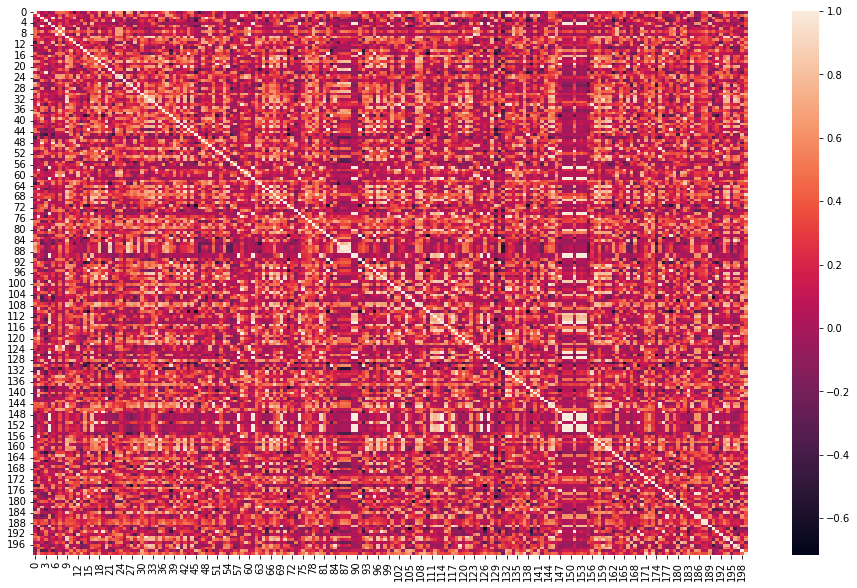

In [19]:
plt.figure(figsize=(16, 10))
sns.heatmap(corr2)

In [20]:
movie_title = user_movie_rating.columns
movie_title_list = list(movie_title)
coffey_hands = movie_title_list.index("Guardians of the Galaxy (2014)")

In [21]:
corr_coffey_hands  = corr[coffey_hands]
list(movie_title[(corr_coffey_hands >= 0.9)])[:50] # 마블의 가디언즈 오브 갤럭시 영화를 기준으로 비슷한 영화를 뽑아봤습니다.
                                                   # 10000BC, 엔트맨, 어벤저스 영화 등이 보이는 것을 알 수 있습니다.

['10,000 BC (2008)',
 '2 Guns (2013)',
 '2012 (2009)',
 '21 (2008)',
 '300: Rise of an Empire (2014)',
 'Abduction (2011)',
 'Adjustment Bureau, The (2011)',
 'Adventures of Tintin, The (2011)',
 'Alice in Wonderland (2010)',
 'Amazing Spider-Man, The (2012)',
 'Angels & Demons (2009)',
 'Ant-Man (2015)',
 'Avatar (2009)',
 'Avengers, The (2012)',
 'Avengers: Age of Ultron (2015)',
 'Batman: The Dark Knight Returns, Part 1 (2012)',
 'Batman: The Dark Knight Returns, Part 2 (2013)',
 'Battle: Los Angeles (2011)',
 'Beowulf (2007)',
 'Big Hero 6 (2014)',
 'Bolt (2008)',
 'Book of Eli, The (2010)',
 'Brave (2012)',
 'Captain America: Civil War (2016)',
 'Captain America: The First Avenger (2011)',
 'Captain America: The Winter Soldier (2014)',
 'Chronicle (2012)',
 'Click (2006)',
 'Cloverfield (2008)',
 'Cop Out (2010)',
 'Dark Knight Rises, The (2012)',
 'Diary of a Wimpy Kid (2010)',
 'District 9 (2009)',
 'Dredd (2012)',
 'Drillbit Taylor (2008)',
 'Déjà Vu (Deja Vu) (2006)',
 'Edge o